In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [2]:
# Example DataFrame: synthetic time series
np.random.seed(42)
dates = pd.date_range(start='2020-01-01', periods=500, freq='D')
data = np.sin(np.linspace(0, 50, 500)) + np.random.normal(scale=0.5, size=500)
df = pd.DataFrame({'date': dates, 'value': data})
df.set_index('date', inplace=True)

# View data
df.head()


,value
date,
2020-01-01,0.248357
2020-01-02,0.030901
2020-01-03,0.522906
2020-01-04,1.057609
2020-01-05,0.273080


In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['value']])


In [4]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

n_steps = 20  # use past 20 values to predict next
X, y = create_sequences(scaled_data, n_steps)

# Reshape X to (samples, timesteps, features) for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [6]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.1768 - val_loss: 0.0345
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0305 - val_loss: 0.0190
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0189 - val_loss: 0.0216
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0181 - val_loss: 0.0203
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0194 - val_loss: 0.0190
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0186 - val_loss: 0.0188
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0187 - val_loss: 0.0172
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0178 - val_loss: 0.0172
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0180 - val_loss: 0.0163
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0156 - val_loss: 0.0159
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0157 - val_loss: 0.0153
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0

In [10]:
y_pred = model.predict(X_test)
mse = np.mean(np.square(y_pred - y_test))
print(f"Mean Squared Error: {mse}")

# Invert scaling
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Mean Squared Error: 0.04031943838940703


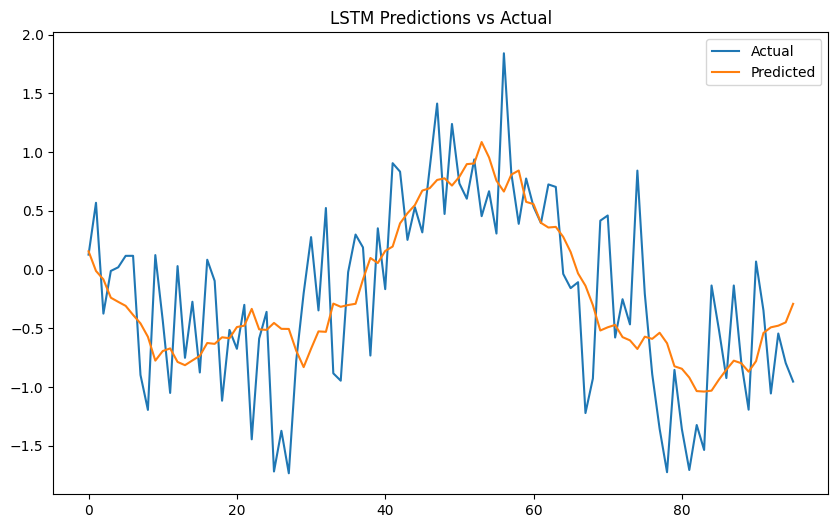

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.legend()
plt.title('LSTM Predictions vs Actual')
plt.show()
